## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Below is my pipeline using examples step by step. Then there is the video code, finally a discussion. Example images with their corresponding file names in my GitHub are provided through the write up.  

---
## First, I'll compute the camera calibration using chessboard images

Taking the given chessboard calibration cameras, I used OpenCV to find the corresponding corners to find the correct calibration matrix for given images using our camera. 

An example frame is under the file name 'DistortedUnDistorted.png'. 

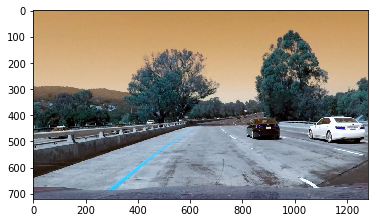

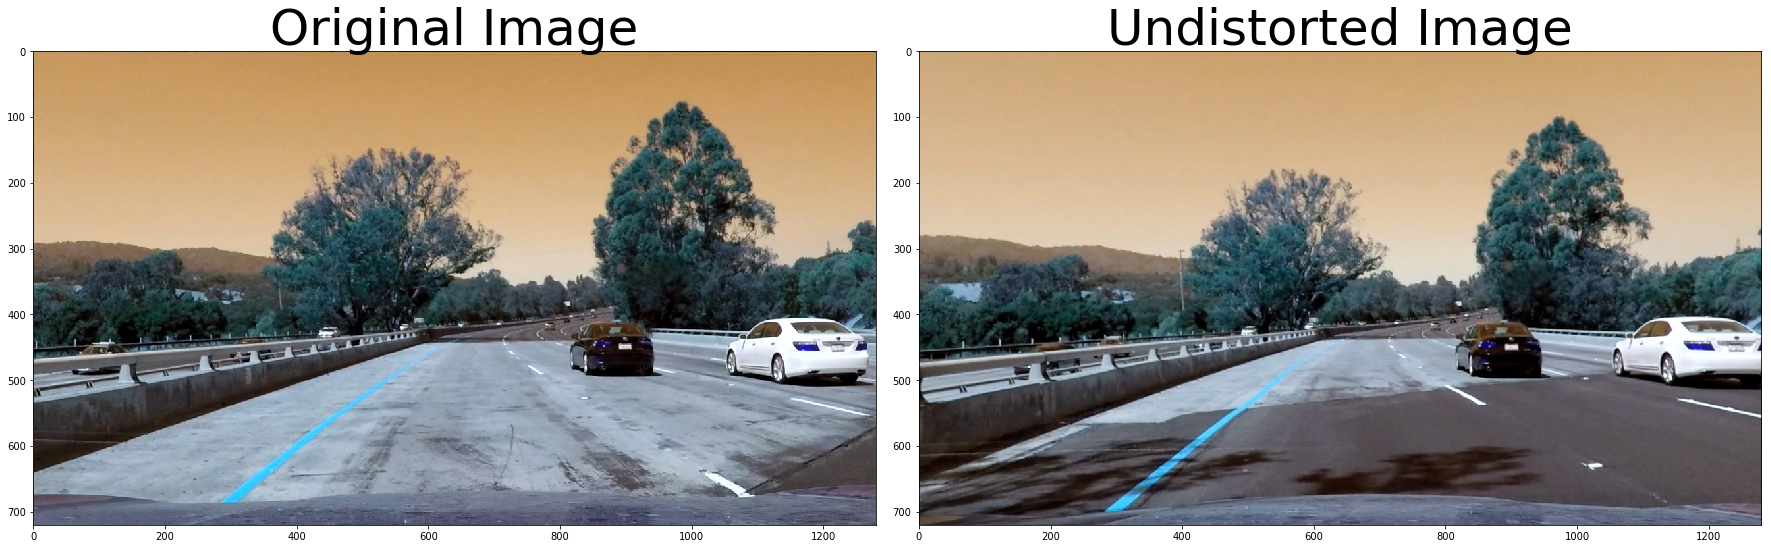

In [22]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)      
        
        # find undistort matrix
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        # undist = cv2.undistort(img, mtx, dist, None, mtx)
      

# undistort test images

images = glob.glob('../test_images/test*.jpg') # read in the 6 test images
test = cv2.imread('../test_images/test1.jpg')
plt.imshow(test)
undist_images = [] # empty array for the 6 undistorted images

for img in images:
    img = cv2.imread(img)
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_images.append(img_undist) # create array of test images that are now undistorted
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_images[1])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


## Use color transforms, gradients, etc., to create a thresholded binary image.

I used a combination of color transforms and gradient to display the lane lines more clearly. First, the Sobel operator with respect to the x direction did the better job of finding the lane lines. Our Sobel operator does this by finding the gradient and displaying only those pixels between our pre-determined threshold. In addition to finding the corresponding pixels through a gradient filter, I also use a color channel, specifically HLS. I find that the S channel (saturation) does a good job of picking up the lines. To get the best of both worlds, I combine the two filters of gradient and color space to get one binary image which picks up the lines even better. 

An example frame is under the file name 'UnDistortedTransform.png'. 


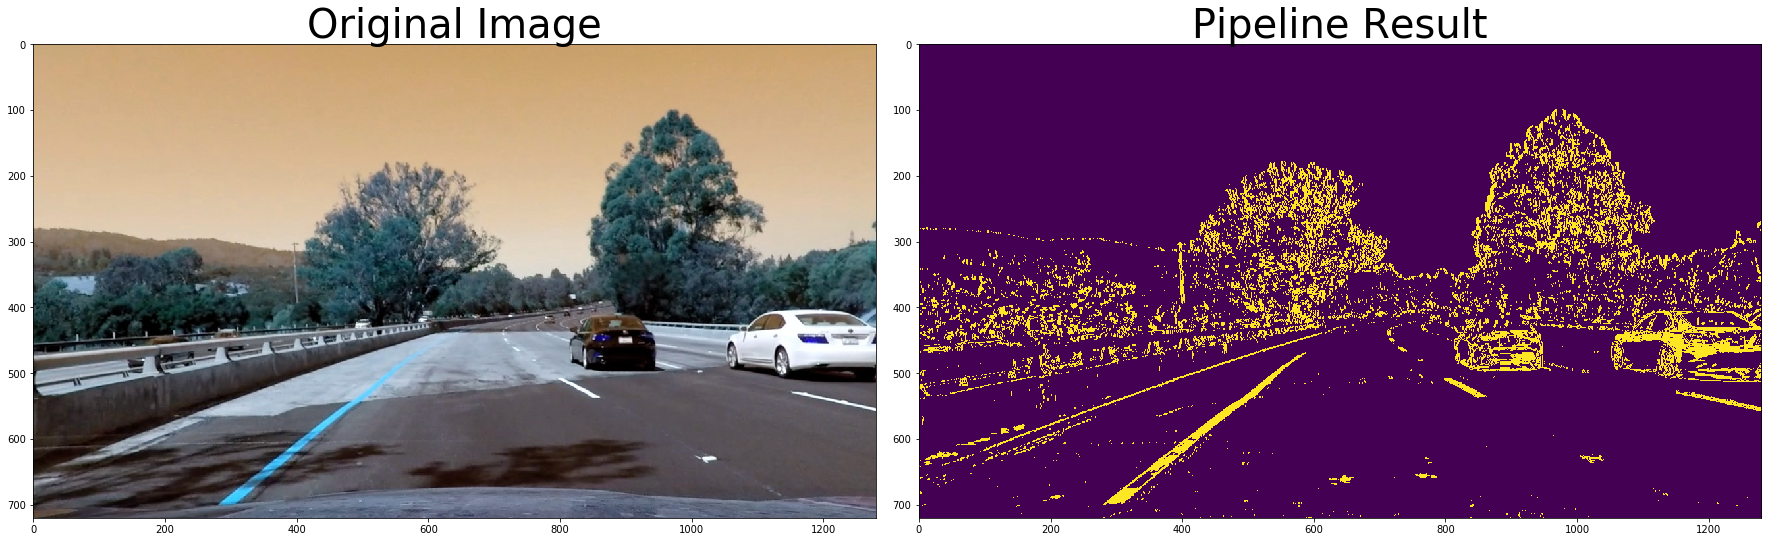

In [24]:
test = undist_images[1]

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

    
result = pipeline(test)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

## Perspective Transform

Now that I have a binary image that picks up the lanes clearly, I need a better view to decide where exactly in the frame the lanes are. I use a perspective transform to get a view of the road from above. I pick four points in the source image and destination image that represent a rectangle to aid in the transformation which is then applied to the rest of the image. I used suggested points to do this. The output is an image that makes it much clearer to see where the lane lines are. 

An example frame is under the file name 'TransformPerspective.png'.



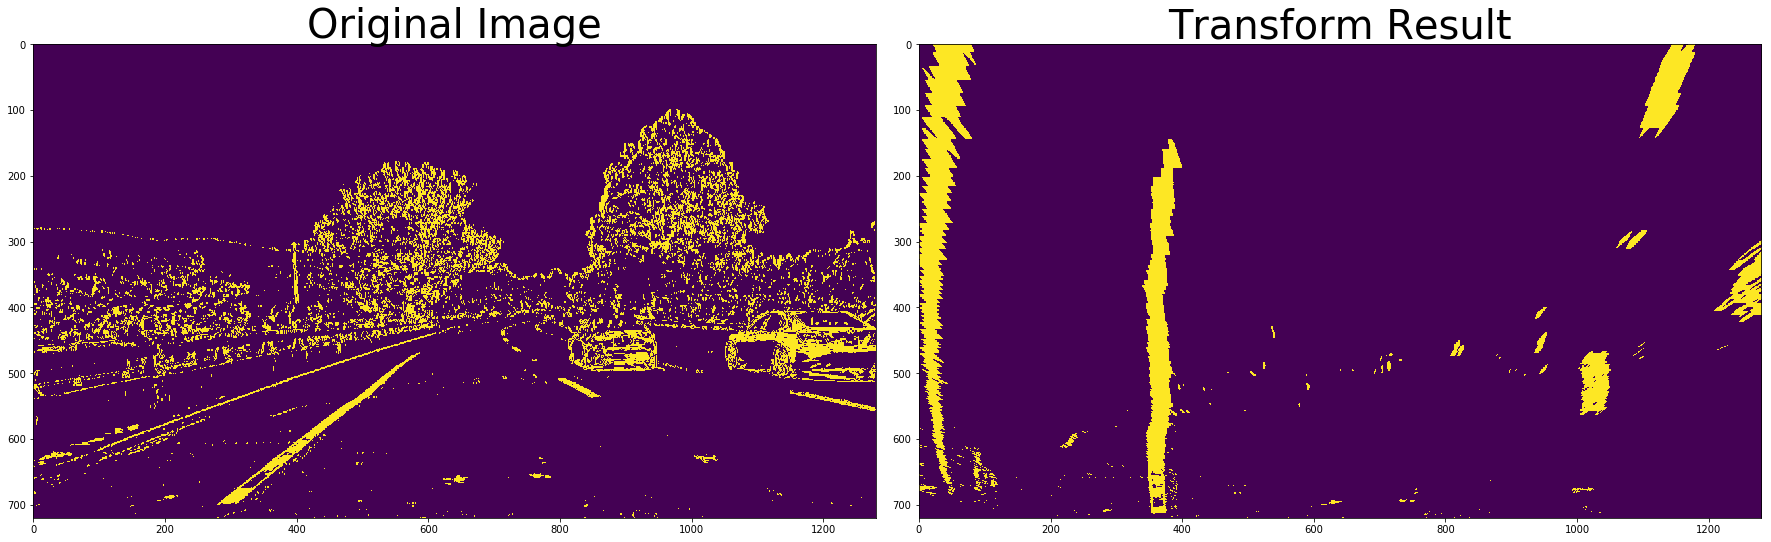

In [26]:
offset = 100
img_size = (undist_images[1].shape[1],undist_images[1].shape[0])
src = np.float32( [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100], 
                   [((img_size[0] / 6) - 10), img_size[1]], 
                   [(img_size[0] * 5 / 6) + 60, img_size[1]],
                   [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]]) 
dst = np.float32( [[(img_size[0] / 4), 0], [(img_size[0] / 4), img_size[1]], 
                   [(img_size[0] * 3 / 4), img_size[1]], [(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(result, M, img_size)

line_result = np.copy(test)*0 
line_warped = np.copy(test)*0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

#srcpt1x = int(img_size[0] / 2 - 55)
#srcpt1y = int(img_size[1] / 2 + 100)
#srcpt2x = int(img_size[0] / 6 - 10)
#srcpt2y = int(img_size[1])
 

#cv2.line(line_result,(srcpt1x,srcpt1y),(srcpt2x,srcpt2y),(255,0,0),10)
#cv2.line(line_result,(),(),(255,0,0),10)

#new_result = cv2.addWeighted(image, 0.5, line_result, 1, 0) 
ax1.imshow(result)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Transform Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary. Determine Curvature.

With the perspective transform image, I can now find the lanes more clearly. Using a histogram method, I detected the pixels that represented lanes starting from the bottom of image. Then using this same method, but moving the "bottom" of the image higher using several sliding windows, I detected the rest of the lane higher on the image. While doing this, I was able to detect the curvature of the lane through iterating each window (in my code, I have used 9 windows per frame) by extracting the starting pixel positions for each window and detecting the change through each window. After detecting the curvature, I was then able to fit a polymonial for the left and right lane respectively to fill out the lanes specifically using np.polyfit. Finally, using a polymonial, I was able to fill in the lanes. 

An example of this process is under the file name 'Polyfit.png'

4829.53226422 1699.81605683


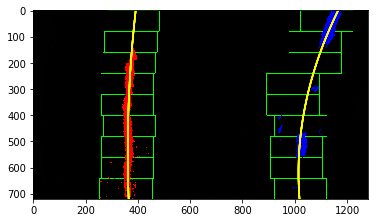

In [27]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)

    return [out_img, left_curverad, right_curverad,ploty,left_fitx,right_fitx]

out_img = fit_polynomial(warped)[0]
left_curve = fit_polynomial(warped)[1]
right_curve = fit_polynomial(warped)[2]
ploty = fit_polynomial(warped)[3]
left_fitx = fit_polynomial(warped)[4]
right_fitx = fit_polynomial(warped)[5]

plt.imshow(out_img)
print(left_curve,right_curve)



## Warp back onto original image

The final step of this pipeline is to warp the lanes back onto the original image with the radius of curvature and position of the vechicle with respect to the center. Given that we now have the position of the lane from before, we can now use the inverse of transform matrix to find the corresponding position on the original frame. 

The curvature of the lanes is found, by the just giving the mean of the two curvatures of the left and right lane. The center positon is given by the starting position of the lanes at the bottom relative to the middle of the whole of the frame. A negative number will mean the vehicle is left of center. 

Since everything in our code is given in pixels, we need to convert these back to meters using the following calculations. For x, 3.7/700 is meters per pixel and for y, 30/720 meters per pixel to give the correct calculations in the real world. 

An example frame of this under the file name 'Outputframe.png'

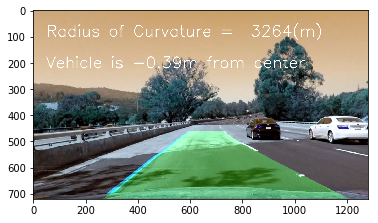

In [30]:
Minv = np.linalg.inv(M)
xm_per_pix = 3.7/700

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (test.shape[1], test.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(test, 1, newwarp, 0.3, 0)

## calculate details of the frame
curvature = int(np.mean([left_curve,right_curve]))
curvature = str(curvature)
center_img = (result.shape[1] / 2) * xm_per_pix
center_lane = np.mean([left_fitx,right_fitx])*xm_per_pix
center_lane = round(center_lane,2) 
center_img = round(center_img,2)
center = center_img - center_lane
center = str(center)

# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
# fontScale 
fontScale = 2
# Blue color in BGR 
color = (255, 255, 255) 
# Line thickness of 2 px 
thickness = 2
# Using cv2.putText() method 
result = cv2.putText(result,'Radius of Curvature =  ' + curvature +'(m)', (50,100), font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
result = cv2.putText(result,'Vehicle is ' + center +'m' +' from center', (50,220), font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
plt.imshow(result)



## Pipeline

Below is the final pipeline for the project video. Make sure to run the calibration cell of the camera first from above. 

In [16]:
## make sure to run calibration of camera cell first

def process_pipeline(image):
    
    ## undistort image frame
    img = cv2.undistort(image, mtx, dist, None, mtx)
    
    ## create threshold binary image
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    s_thresh=(170, 255)
    sx_thresh=(20, 100)
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    ## perspective transform

    img_size = (undist_images[1].shape[1],undist_images[1].shape[0])
    src = np.float32( [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100], 
                   [((img_size[0] / 6) - 10), img_size[1]], 
                   [(img_size[0] * 5 / 6) + 60, img_size[1]],
                   [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]]) 
    dst = np.float32( [[(img_size[0] / 4), 0], [(img_size[0] / 4), img_size[1]], 
                   [(img_size[0] * 3 / 4), img_size[1]], [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size)
    
    ## find lanes
    
     # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## returns out_img

    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Calculation of R_curve (radius of curvature)
    left_curve = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curve = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    Minv = np.linalg.inv(M)
    xm_per_pix = 3.7/700

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    ## calculate details of the frame
    curvature = int(np.mean([left_curve,right_curve]))
    curvature = str(curvature)
    center_img = (result.shape[1] / 2) * xm_per_pix
    center_lane = np.mean([left_fitx,right_fitx])*xm_per_pix
    center_lane = round(center_lane,2) 
    center_img = round(center_img,2)
    center = center_img - center_lane
    center = str(center)

    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # fontScale 
    fontScale = 2
    # Blue color in BGR 
    color = (255, 255, 255) 
    # Line thickness of 2 px 
    thickness = 2
    # Using cv2.putText() method 
    result = cv2.putText(result,'Radius of Curvature =  ' + curvature +'(m)', (50,100), font,  
                       fontScale, color, thickness, cv2.LINE_AA) 
    result = cv2.putText(result,'Vehicle is ' + center +'m' +' from center', (50,220), font,  
                       fontScale, color, thickness, cv2.LINE_AA) 

    return result

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
in_clip = VideoFileClip('../project_video.mp4')
out_filename = 'processed_project_video.mp4'
out_clip = in_clip.fl_image(process_pipeline)
%time out_clip.write_videofile(out_filename, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|█████████▉| 1260/1261 [04:04<00:00,  5.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

CPU times: user 1min 56s, sys: 2.18 s, total: 1min 58s
Wall time: 4min 7s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_filename))

## Discussion 

For the most part, the tracking runs smoothly. There is some issues when the vehicle passes over small bridges where the lanes don't seem to be marked clearly as the gradient and the color does not seem sharp enough in the frame. However, in these cases the boundary is found to be the barrier of the bridge for just a second or two which is not the worst case as the car will stay on the road. The measurements of center and curvature are also thrown off as a result though. An improvement can be made in this regard. 

Another improvement that can be made is in terms of algorithm speed. Instead of searching the entire frame for the lane, a filter could be provided to only search within a certain portion of the image to speed things up. 